# Generation of a occupancy grid map of a generated world

The generation of an occupancy grid map can be used as a ground truth map input for a navigation algorithm.

This example randomly places cuboids and cylinders in an empty world and then generates two types of ground maps.

In one, all objects (apart from the ground plane) are included, and on the second, only the static objects are included.

In [1]:
import warnings

warnings.filterwarnings("ignore")

from pcg_gazebo.generators import WorldGenerator
from pcg_gazebo.visualization import plot_workspace, plot_occupancy_grid
from pcg_gazebo.generators.creators import box_factory
from pcg_gazebo.utils import generate_random_string

world_gen = WorldGenerator()

First, the assets manager must be populated. The random pose engine will use it to pull all the models to populate the world.

The following command adds a dynamic box generator to the list of assets. Dynamic boxes have a mass and moments of inertia computed from the `mass` input and the dimensions of the cuboids generated.

By giving an inline function with the command to compute randomized inputs for the box's `size` and `mass`, each new instance of the `box` model will have it's parameter computed at creation.

In [2]:
world_gen.add_asset(
    tag='dyn_box',
    description=dict(
        type='box',
        args=dict(
            size="5 * __import__('pcg_gazebo').random.rand(3)",
            name='cuboid',
            mass="max(0.1, __import__('pcg_gazebo').random.rand())",
            color='xkcd'
        )
    )
)

# Check if models where included correctly
print('Asset is available for world generation=', 'dyn_box' in world_gen.assets.tags)

Asset is available for world generation= True


Creating the static cylinders uses a similar input for the assets manager. 
By omitting the `mass`, the generated models will be set as `static`.

In [3]:
world_gen.add_asset(
    tag='static_cylinder',
    description=dict(
        type='cylinder',
        args=dict(
            length="2 * __import__('pcg_gazebo').random.rand()",
            radius="2 * __import__('pcg_gazebo').random.rand()",
            name='cylinder',
            color='xkcd'
        )
    )
)

# Check if models where included correctly
print('Asset is available for world generation=', 'static_cylinder' in world_gen.assets.tags)

Asset is available for world generation= True


Add a constraint to ensure all boxes are placed on top of ground plane

In [4]:
world_gen.add_constraint(
    name='tangent_to_ground_plane',
    type='tangent',
    frame='world',
    reference=dict(
        type='plane',
        args=dict(
            origin=[0, 0, 0],
            normal=[0, 0, 1]
        )
    )
)

print('List of constraints=', list(world_gen.constraints.tags))

List of constraints= ['tangent_to_ground_plane']


Add 2D workspace constraint defining where the boxes should be spawned in the world

List of constraints= ['tangent_to_ground_plane', 'my_workspace']


(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f01a80cc5c0>)

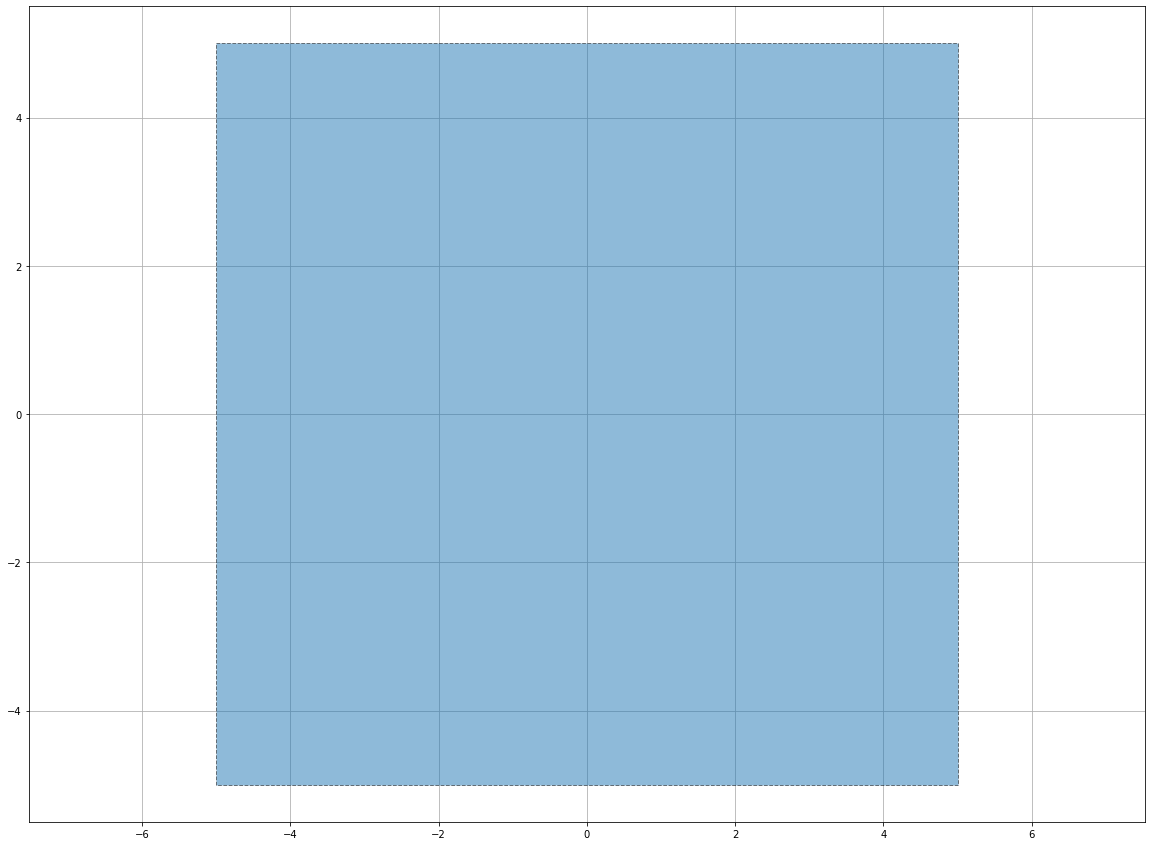

In [5]:
world_gen.add_constraint(
    name='my_workspace',
    type='workspace',
    frame='world',
    geometry_type='area',
    points=[
        [-5, -5, 0],
        [-5, 5, 0],
        [5, 5, 0],
        [5, -5, 0],
    ]
)

print('List of constraints=', list(world_gen.constraints.tags))

plot_workspace(workspace=world_gen.constraints.get('my_workspace'))

Add ground plane to the world in a fixed position

In [6]:
floor_model = box_factory(
    size=[
        [20, 20, 0.01]
    ],
    mass=1,
    use_permutation=True,
    name='box_floor'
)[0]
floor_model.name = 'box_floor'

world_gen.add_asset(tag='box_floor', description=floor_model)

world_gen.add_engine(
    engine_name='fixed_pose',
    tag='gp_engine',
    models=['box_floor'],
    poses=[[0, 0, -0.005, 0, 0, 0]])
world_gen.set_model_as_ground_plane('box_floor')

True

Add a random pose engine to place the boxes in the world

In [7]:
NUM_BOXES = 1
NUM_CYLINDER = 1

placement_policy = dict(
    models=['dyn_box', 'static_cylinder'],
    config=[
        dict(
            dofs=['x', 'y'],            
            tag='workspace',
            workspace='my_workspace'
        ),
        dict(
            dofs=['yaw'],            
            tag='uniform',                            
            min=-3.141592653589793,
            max=3.141592653589793               
        )
    ]
)

world_gen.add_engine(
    tag='box_placement',
    engine_name='random_pose',
    models=['dyn_box', 'static_cylinder'],
    max_num=dict(
        dyn_box=NUM_BOXES,
        static_cylinder=NUM_CYLINDER),
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    constraints=[
        dict(
            model='dyn_box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='static_cylinder',
            constraint='tangent_to_ground_plane')
    ]
)

True

Run the engines to generate the world

In [8]:
world_gen.run_engines()

True

In [9]:
print(world_gen.world.models.keys())

dict_keys(['box_floor'])


In [10]:
world_gen.world.create_scene().show()

Next the grid map can be generated. It is important to check if the dynamic models should be included in the plot. 
That can be done using the `static_models_only` input.
The example below shows a grid map with both dynamic and static models. 

If is important to also include a list of the models that are flagged as part of the ground plane (e.g. floors, walls) in the `ground_plane_models`, since they are computed both for occupancy spots and the size of the free space.

To remove the ground plane from the map, the `with_ground_plane` flag input must be set to `False`.

2020-04-14 22:13:05,230 | WARNING | occupancy | List of models is empty, cannot compute occupancy grid


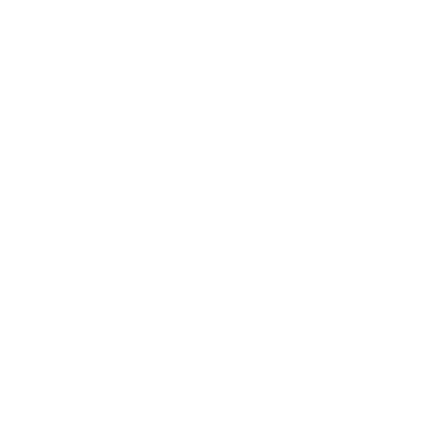

In [11]:
import matplotlib.pyplot as pyplot
fig = plot_occupancy_grid(world_gen.world.models, with_ground_plane=False, static_models_only=False, ground_plane_models=['box_floor'])
pyplot.show()

The example below shows a grid map with only static models. 

2020-04-14 22:13:06,144 | WARNING | occupancy | List of models is empty, cannot compute occupancy grid


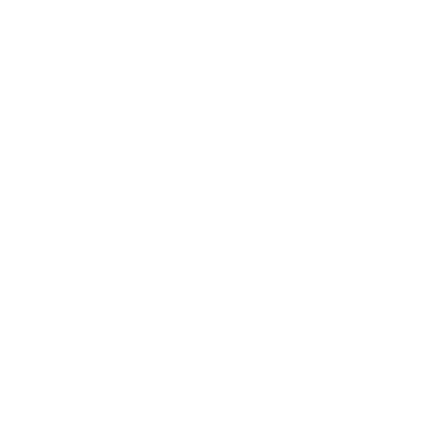

In [12]:
fig = plot_occupancy_grid(
    world_gen.world.models,
    with_ground_plane=False,
    static_models_only=True,
    ground_plane_models=['box_floor'])
pyplot.show()

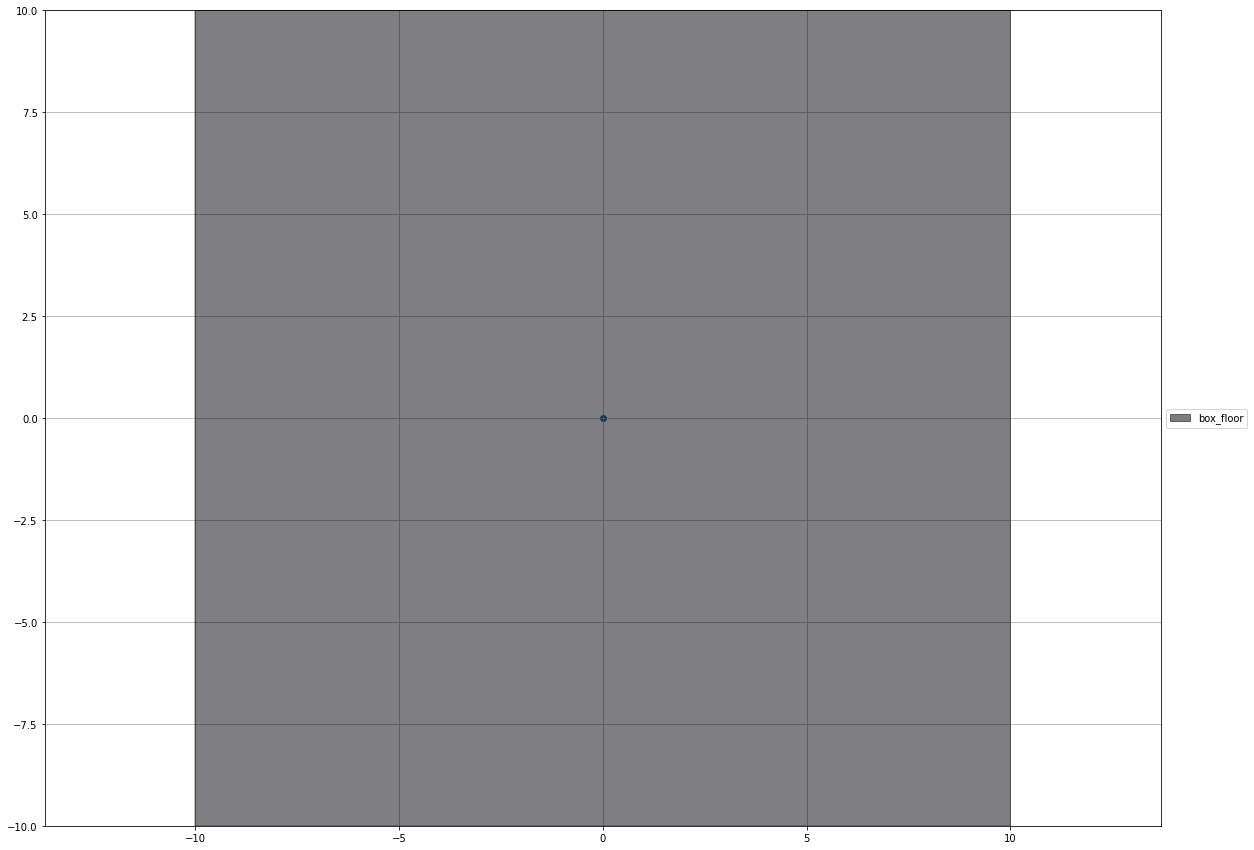

In [13]:
fig = world_gen.world.plot_footprints(engine='matplotlib')

## Generating a single room scenario

### Generating walls from the triangulation of random points

(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f01a77fa400>)

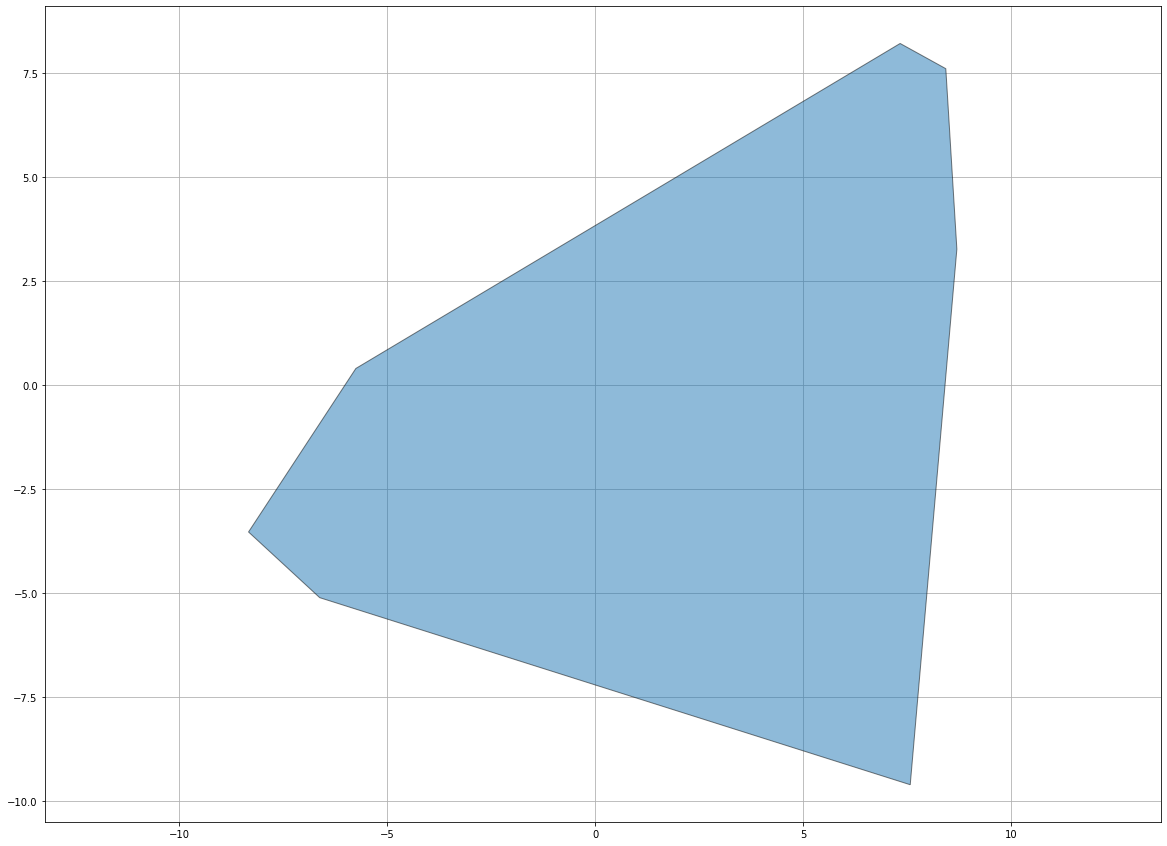

In [14]:
from pcg_gazebo.generators.creators import extrude
from pcg_gazebo.generators.shapes import random_points_to_triangulation
from pcg_gazebo.visualization import plot_shapely_geometry, plot_mesh
from pcg_gazebo.simulation import SimulationModel

n_points = 10

# Generate the polygon from where the walls will be extruded
wall_polygon = random_points_to_triangulation(n_points)

plot_shapely_geometry(wall_polygon)

Extrude the boundaries of the polygon to create walls.

In [15]:
wall_thickness = 0.15
wall_height = 2

walls_model = extrude(
    polygon=wall_polygon,
    thickness=wall_thickness,
    height=wall_height,
    pose=[0, 0, wall_height / 2., 0, 0, 0],
    extrude_boundaries=True,
    color='xkcd')
walls_model.name = 'walls'

Create a new world generator

In [16]:
# Reset world generator
world_gen.init()
world_gen.engines.reset()

# Add walls and ground plane to the world
world_gen.world.add_model(
    tag=walls_model.name,
    model=walls_model)
world_gen.world.add_model(
    tag='ground_plane',
    model=SimulationModel.from_gazebo_model('ground_plane'))

'ground_plane'

Retrieve the free space within the walls to place objects

In [17]:
free_space_polygon = world_gen.world.get_free_space_polygon(
    ground_plane_models=[walls_model.name],
    ignore_models=['ground_plane'])

Set the free space as the workspace were the objects will be placed

(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f01a403e9b0>)

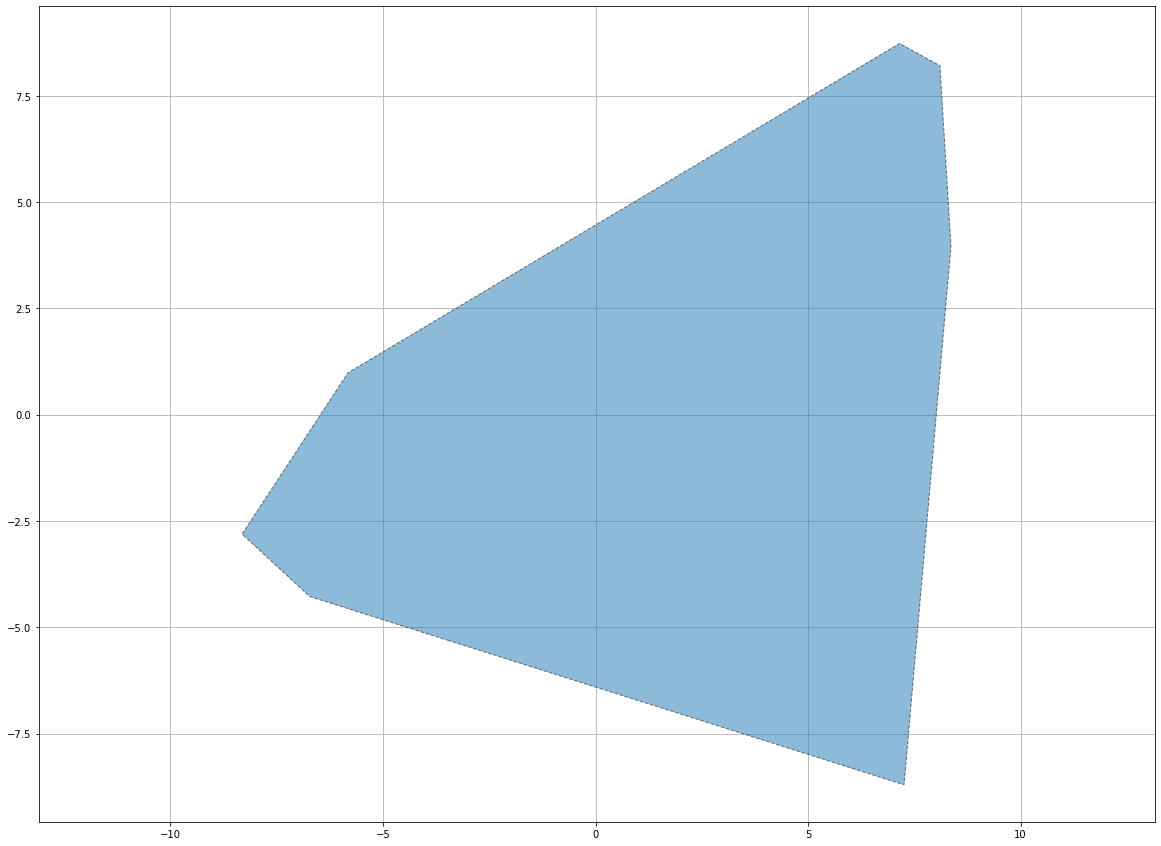

In [18]:
# Add the workspace constraint to the generator
world_gen.add_constraint(
    name='room_workspace',
    type='workspace',
    frame='world',
    geometry_type='polygon',
    polygon=free_space_polygon
)

plot_workspace(world_gen.constraints.get('room_workspace'))

In [19]:
NUM_BOXES = 4
NUM_CYLINDER = 4

placement_policy = dict(
    models=['dyn_box', 'static_cylinder'],
    config=[
        dict(
            dofs=['x', 'y'],            
            tag='workspace',
            workspace='room_workspace'
        ),
        dict(
            dofs=['yaw'],            
            tag='uniform',                            
            min=-3.141592653589793,
            max=3.141592653589793               
        )
    ]
)

world_gen.add_engine(
    tag=generate_random_string(5),
    engine_name='random_pose',
    models=['dyn_box', 'static_cylinder'],
    max_num=dict(
        dyn_box=NUM_BOXES,
        static_cylinder=NUM_CYLINDER),
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    constraints=[
        dict(
            model='dyn_box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='static_cylinder',
            constraint='tangent_to_ground_plane')
    ]
)

True

In [20]:
world_gen.run_engines(attach_models=True)

True

In [21]:
world_gen.world.models.keys()

dict_keys(['walls', 'ground_plane', 'static_cylinder', 'static_cylinder_1', 'dyn_box', 'dyn_box_1', 'static_cylinder_2', 'static_cylinder_3', 'dyn_box_2', 'dyn_box_3'])

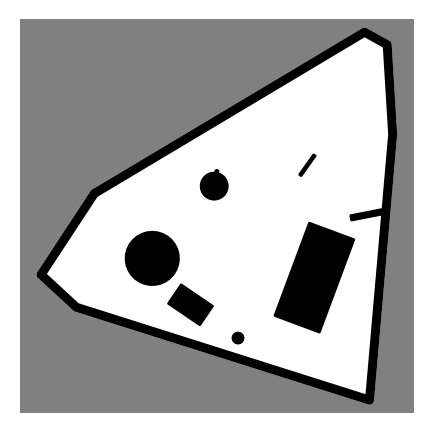

In [22]:
fig = plot_occupancy_grid(
    world_gen.world.models,
    with_ground_plane=True,
    static_models_only=False,
    exclude_contains=['ground_plane'],
    ground_plane_models=[walls_model.name])
pyplot.show()

### Generating walls from a random rectangle

In [23]:
from pcg_gazebo.generators.shapes import random_rectangle

wall_polygon = random_rectangle(
    delta_x_min=10, delta_x_max=15, delta_y_min=10, delta_y_max=15)

walls_model = extrude(
    polygon=wall_polygon,
    thickness=wall_thickness,
    height=wall_height,
    pose=[0, 0, wall_height / 2., 0, 0, 0],
    extrude_boundaries=True,
    color='xkcd')
walls_model.name = 'walls'

In [24]:
# Reset world generator
world_gen.init()
world_gen.engines.reset()

# Add walls and ground plane to the world
world_gen.world.add_model(
    tag=walls_model.name,
    model=walls_model)
world_gen.world.add_model(
    tag='ground_plane',
    model=SimulationModel.from_gazebo_model('ground_plane'))

'ground_plane'

2020-04-14 22:13:55,196 | WARNING | constraints_manager | Constraint with name <room_workspace> already exists and has different parameters, existing constraint will be overwritten


(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f018464af98>)

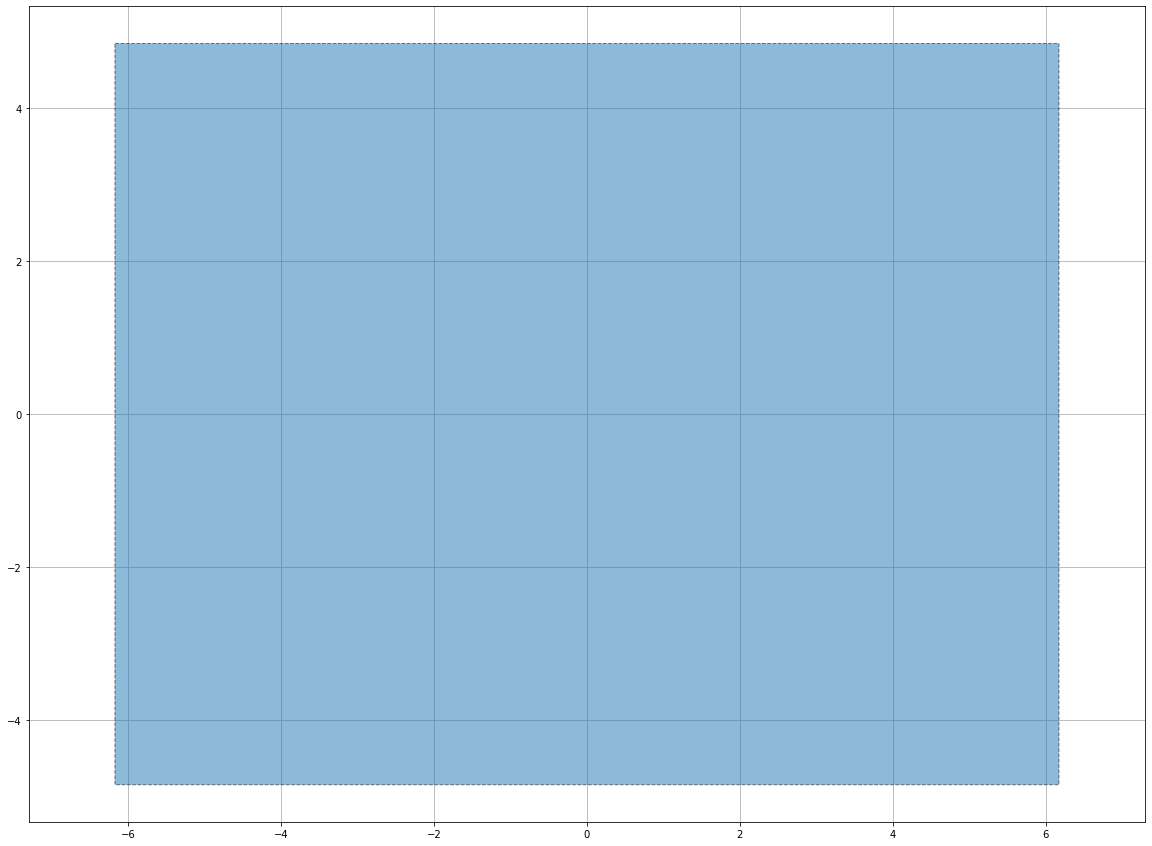

In [25]:
free_space_polygon = world_gen.world.get_free_space_polygon(
    ground_plane_models=[walls_model.name],
    ignore_models=['ground_plane'])

# Add the workspace constraint to the generator
world_gen.add_constraint(
    name='room_workspace',
    type='workspace',
    frame='world',
    geometry_type='polygon',
    polygon=free_space_polygon
)

plot_workspace(world_gen.constraints.get('room_workspace'))

In [26]:
NUM_BOXES = 4
NUM_CYLINDER = 4

placement_policy = dict(
    models=['dyn_box', 'static_cylinder'],
    config=[
        dict(
            dofs=['x', 'y'],            
            tag='workspace',
            workspace='room_workspace'
        ),
        dict(
            dofs=['yaw'],            
            tag='uniform',                            
            min=-3.141592653589793,
            max=3.141592653589793               
        )
    ]
)

world_gen.add_engine(
    tag=generate_random_string(5),
    engine_name='random_pose',
    models=['dyn_box', 'static_cylinder'],
    max_num=dict(
        dyn_box=NUM_BOXES,
        static_cylinder=NUM_CYLINDER),
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    constraints=[
        dict(
            model='dyn_box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='static_cylinder',
            constraint='tangent_to_ground_plane')
    ]
)

True

In [27]:
world_gen.run_engines(attach_models=True)

True

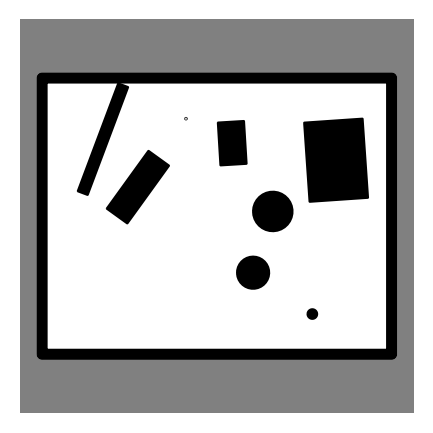

In [28]:
fig = plot_occupancy_grid(
    world_gen.world.models,
    with_ground_plane=True,
    static_models_only=False,
    exclude_contains=['ground_plane'],
    ground_plane_models=[walls_model.name])
pyplot.show()

### Generating walls from merging random rectangles

In [29]:
from pcg_gazebo.generators.shapes import random_rectangles

wall_polygon = random_rectangles(
    n_rect=5, delta_x_min=10, delta_x_max=15, delta_y_min=10, delta_y_max=15)

walls_model = extrude(
    polygon=wall_polygon,
    thickness=wall_thickness,
    height=wall_height,
    pose=[0, 0, wall_height / 2., 0, 0, 0],
    extrude_boundaries=True,
    color='xkcd')
walls_model.name = 'walls'

In [30]:
# Reset world generator
world_gen.init()
world_gen.engines.reset()

# Add walls and ground plane to the world
world_gen.world.add_model(
    tag=walls_model.name,
    model=walls_model)
world_gen.world.add_model(
    tag='ground_plane',
    model=SimulationModel.from_gazebo_model('ground_plane'))

'ground_plane'

2020-04-14 22:15:30,692 | WARNING | constraints_manager | Constraint with name <room_workspace> already exists and has different parameters, existing constraint will be overwritten


(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f01845d35f8>)

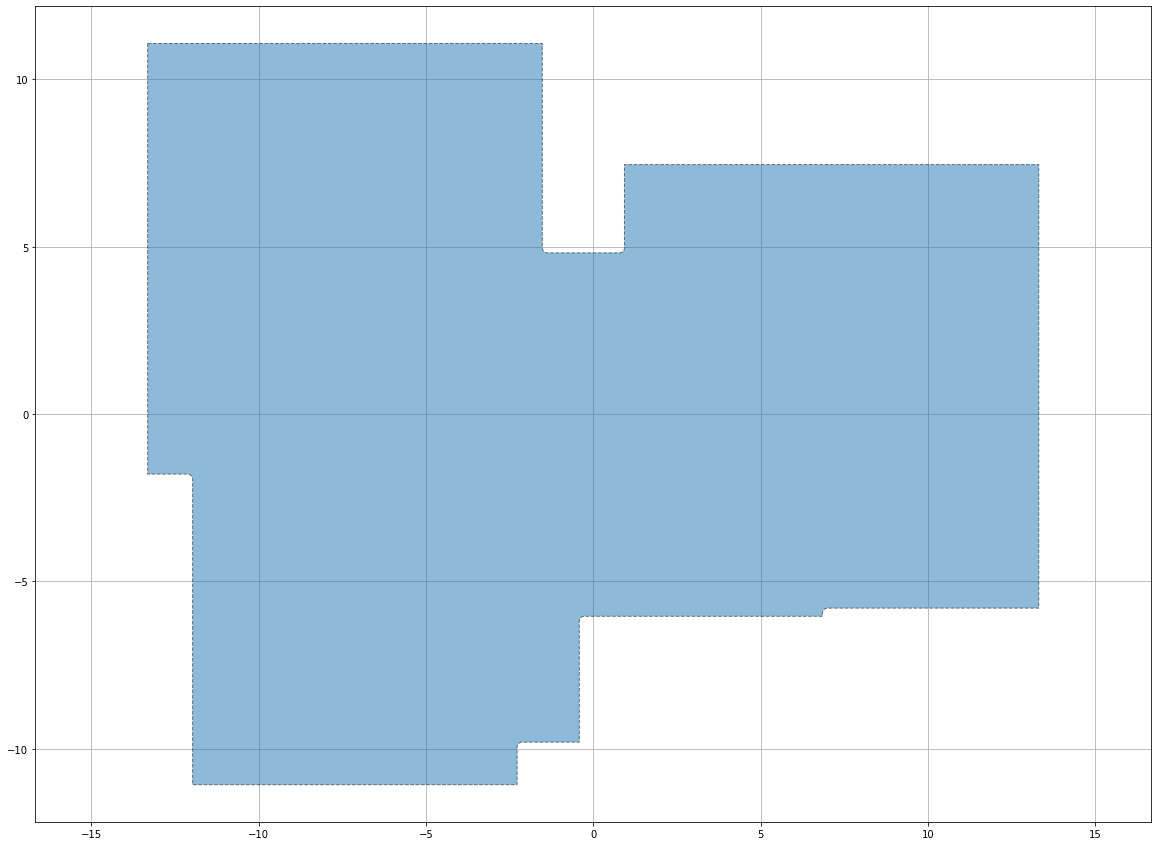

In [31]:
free_space_polygon = world_gen.world.get_free_space_polygon(
    ground_plane_models=[walls_model.name],
    ignore_models=['ground_plane'])

# Add the workspace constraint to the generator
world_gen.add_constraint(
    name='room_workspace',
    type='workspace',
    frame='world',
    geometry_type='polygon',
    polygon=free_space_polygon
)

plot_workspace(world_gen.constraints.get('room_workspace'))

In [32]:
NUM_BOXES = 4
NUM_CYLINDER = 4

placement_policy = dict(
    models=['dyn_box', 'static_cylinder'],
    config=[
        dict(
            dofs=['x', 'y'],            
            tag='workspace',
            workspace='room_workspace'
        ),
        dict(
            dofs=['yaw'],            
            tag='uniform',                            
            min=-3.141592653589793,
            max=3.141592653589793               
        )
    ]
)

world_gen.add_engine(
    tag=generate_random_string(5),
    engine_name='random_pose',
    models=['dyn_box', 'static_cylinder'],
    max_num=dict(
        dyn_box=NUM_BOXES,
        static_cylinder=NUM_CYLINDER),
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    constraints=[
        dict(
            model='dyn_box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='static_cylinder',
            constraint='tangent_to_ground_plane')
    ]
)

True

In [33]:
world_gen.run_engines(attach_models=True)

True

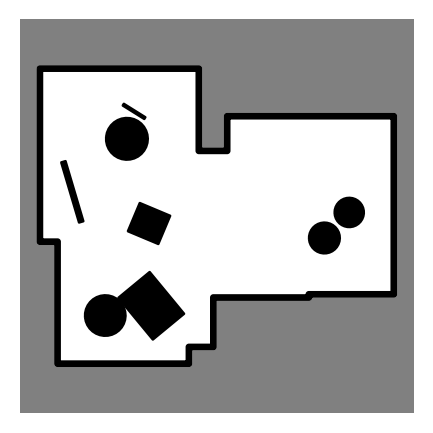

In [34]:
fig = plot_occupancy_grid(world_gen.world.models, with_ground_plane=True, static_models_only=False, exclude_contains=['ground_plane'], ground_plane_models=[walls_model.name])
pyplot.show()